In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy, json, requests
import string, re
import csv
import nltk
import gensim
import tqdm
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array

In [149]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [150]:
print("Kata Kunci = ppkm")
print(
    "Topik yang akan di analisis adalah ppkm, untuk mencari sentimen netizen mengenai kebijakan ppkm menjelang libur nataru. apakah netizen menyabut dengan baik kebijakan ppkm menjelang libur nataru atau tidak?" 
    )

Kata Kunci = ppkm
Topik yang akan di analisis adalah ppkm, untuk mencari sentimen netizen mengenai kebijakan ppkm menjelang libur nataru. apakah netizen menyabut dengan baik kebijakan ppkm menjelang libur nataru atau tidak?


* Crawling data dari Twitter dengan keyword "ppkm"

In [151]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

def search_tweet(query, max_result):
    response = tweepy.Cursor(api.search_tweets,
                            q = query,
                            until = '2021-12-12',
                            lang = 'id',
                            tweet_mode = 'extended'
                            ).items(max_result)
    search_result = [tweet.full_text.strip() for tweet in response]
    return search_result

query = 'ppkm -is:retweet'
max_result = 300
result = search_tweet(query, max_result)
tweet_result = [tweet for tweet in result]
df_result = pd.DataFrame(tweet_result, columns=['tweet'])
df_result.to_csv('tweets_ppkm.csv')
print(df_result.head())


                                               tweet
0  @Billy_Rania Waalaikumsalam wr wb \n\nAsyik do...
1  RT @YoutubeILC: “Tapi kenapa dalam baru berapa...
2  Sat samapta Polres Pekalongan melaksanakan gia...
3  RT @7AndraVio7: PPKM Level 3 Semua Wilayah Bat...
4  Susah-susah pak Luhut umumin PPKM dan karantin...


* Scrapping Web dari Portal berita "detik.com", dengan kata kunci "ppkm"

In [152]:
url = 'https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=1'
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36'
}

news = []
count_page = 0
for page in range(0, 11):
    count_page += 1
    req = requests.get(url+str(page), headers=headers)
    soup = bs(req.text, 'html.parser')
    items = soup.findAll('span', 'box_text')
    for item in items:
        titles = item.find('h2', 'title').text
        news.append(titles)

df_news = pd.DataFrame(news, columns=['News'])
df_news.to_csv('news_ppkm.csv')
print(df_news.head())

                                                News
0                             Dua Agenda Muktamar NU
1  Polda Jateng Siapkan 375 Pos Cek Poin saat Nat...
2  Kasus Corona RI 8 Desember Tambah 264, Sembuh 351
3  Mendagri Minta Hindari Istilah PPKM Level 3 Sa...
4  PPKM Level 3 Batal, Begini Aturannya di Yogyak...


In [153]:
data_tweet = pd.read_csv('tweets_ppkm.csv')
data_news = pd.read_csv('news_ppkm.csv')
data_tweet.drop(data_tweet.columns[0], axis=1, inplace=True)
data_news.drop(data_news.columns[0], axis=1, inplace=True)

In [154]:
display(data_tweet)
display(data_news)

,tweet
0,@Billy_Rania Waalaikumsalam wr wb \n\nAsyik do...
1,RT @YoutubeILC: “Tapi kenapa dalam baru berapa...
2,Sat samapta Polres Pekalongan melaksanakan gia...
3,RT @7AndraVio7: PPKM Level 3 Semua Wilayah Bat...
4,Susah-susah pak Luhut umumin PPKM dan karantin...
...,...
295,@kurawa Dia menyuap dan melanggar aturan PPKM.
296,Koramil 08 Tawangmangu - Kamis tanggal 2 Desem...
297,RT @syafniir: Pada dasar nya buat kaum adam......
298,RT @Hilmi28: Sy berharap smg pembatalan PPKM l...


,News
0,Dua Agenda Muktamar NU
1,Polda Jateng Siapkan 375 Pos Cek Poin saat Nat...
2,"Kasus Corona RI 8 Desember Tambah 264, Sembuh 351"
3,Mendagri Minta Hindari Istilah PPKM Level 3 Sa...
4,"PPKM Level 3 Batal, Begini Aturannya di Yogyak..."
...,...
94,"Kaji Syarat PCR Diterapkan Lagi, Luhut: Jangan..."
95,"Pandemi Mereda, Pemerintah Pede Ekonomi RI 202..."
96,Menguliti Penyebab Ekonomi RI Masih Bisa Tumbu...
97,Luhut: Kita Sedang Evaluasi Terapkan Kembali P...


* Data Preprocessing

In [169]:
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("","",string.punctuation))
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    return data

def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian")
    data  = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data

def slang_cleaner(data):
    slang_list = [
        ('elu', 'kamu'),
        ('warge', 'warga'),
        ('aje', 'saja'),
        ('full', 'penuh'),
        ('gue', 'saya'),
        ('gua', 'saya'),
        ('yang', ''),
        ('kamu', ''),
        ('saja', ''),
        ('saya', ''),
        ('liat', 'lihat'),
        ('kagak', 'tidak'),
        ('itu', ' '),
        ('retweet', ''),
        ('rt', 'retweet'),
        ('yg', 'yang'),
        ('up', ''),
        ('a', ''),
        ('speak', 'bicara'),
        ('thread', 'perlakuan'),
        ('tr', ''),
        ('ga', 'tidak'),
        ('ttp', 'tetap'),
        ('ya', 'iya'),
        ('udah', 'sudah'),
        ('aja', 'saja'),
        ('lagii', 'lagi'),
        ('adaa', 'ada'),
        ('karier', 'karir'),
        ('s', ' '),
        ('nya', ' '),
        ('wkwk', ' '),
        ('gua', 'saya'),
        ('si', ' '),
        ('nih', ' '),
        ('cnnindonesisa', ''),
        ('kalo', 'kalau'),
        ('d', ''),
        ('duh', ''),
        ('gak', 'tidak'),
        ('cm', 'hanya'),
        ('univ', 'universitas'),
        ('ra', ' '),
        ('dah', ' '),
        ('indon', 'indonesia'),
        ('udh', 'sudah'),
        ('sih', ''),
        ('anjrkt', ''),
        ('jenengan', 'kamu'),
        ('krn', 'karena'),
        ('jd', 'jadi'),
        ("'", " "),
        (',', ' '),
        ('askrl', ' '),
        ('lu', 'kamu'),
        ('guys', 'teman'),
        ('sm', 'sama'),
        ('mulu', 'selalu'),
        ('emg', 'memang'),
        ('lg','lagi'),
        ('ono', 'ada'),
        ('iki', 'ini'),
        ('kyk', 'seperti'),
        ('gk', 'tidak'),
        ('gt', 'itu'),
        ('dgn','dengan'),
        ('jgn', 'jangan'),
        ('dr', 'dari'),
        ('sy', 'saya'),
        ('thn', 'tahun')
    ]
    
    word_token = word_tokenize(data)
    word_list = []
    
    for word in word_token:
        for slang in slang_list:
            if word.lower() in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    
    data = ' '.join(word_list)
    return data    

In [170]:
#Data Tweet
data_tweet['clean_tweet'] = data_tweet['tweet'].apply(lambda x: case_folding(x))
data_tweet['clean_tweet'] = data_tweet['clean_tweet'].apply(lambda x: word_tokenize(x))
data_tweet['clean_tweet'] = data_tweet['clean_tweet'].apply(lambda x: stopword_cleaner(x))
data_tweet['clean_tweet'] = data_tweet['clean_tweet'].apply(lambda x: slang_cleaner(x))
print(data_tweet)


                                                 tweet  \
0    @Billy_Rania Waalaikumsalam wr wb \n\nAsyik do...   
1    RT @YoutubeILC: “Tapi kenapa dalam baru berapa...   
2    Sat samapta Polres Pekalongan melaksanakan gia...   
3    RT @7AndraVio7: PPKM Level 3 Semua Wilayah Bat...   
4    Susah-susah pak Luhut umumin PPKM dan karantin...   
..                                                 ...   
295     @kurawa Dia menyuap dan melanggar aturan PPKM.   
296  Koramil 08 Tawangmangu - Kamis tanggal 2 Desem...   
297  RT @syafniir: Pada dasar nya buat kaum adam......   
298  RT @Hilmi28: Sy berharap smg pembatalan PPKM l...   
299  Bhabinkamtibmas menghadiri giat penyerahan BLT...   

                                           clean_tweet  
0    rania waalaikumsalam wr wb asyik kalau indones...  
1    retweet diumumkan ppkm level dari eva chaniago...  
2    sat samapta polres pekalongan melaksanakan gia...  
3    retweet ppkm level wilayah batal moeldoko meny...  
4    susah susah l

In [157]:
# Data News
data_news['clean_news'] = data_news['News'].apply(lambda x: case_folding(x))
data_news['clean_news'] = data_news['clean_news'].apply(lambda x: word_tokenize(x))
data_news['clean_news'] = data_news['clean_news'].apply(lambda x: stopword_cleaner(x))
print(data_news)


                                                 News  \
0                              Dua Agenda Muktamar NU   
1   Polda Jateng Siapkan 375 Pos Cek Poin saat Nat...   
2   Kasus Corona RI 8 Desember Tambah 264, Sembuh 351   
3   Mendagri Minta Hindari Istilah PPKM Level 3 Sa...   
4   PPKM Level 3 Batal, Begini Aturannya di Yogyak...   
..                                                ...   
94  Kaji Syarat PCR Diterapkan Lagi, Luhut: Jangan...   
95  Pandemi Mereda, Pemerintah Pede Ekonomi RI 202...   
96  Menguliti Penyebab Ekonomi RI Masih Bisa Tumbu...   
97  Luhut: Kita Sedang Evaluasi Terapkan Kembali P...   
98  Luhut: Ada Kenaikan Kasus Covid-19 di 43 Kabup...   

                                           clean_news  
0                                  agenda muktamar nu  
1             polda jateng siapkan pos cek poin natal  
2                           corona ri desember sembuh  
3   mendagri hindari istilah ppkm level nataru ala...  
4           ppkm level batal aturan

* Text Data Analysis

In [158]:
def char_freq_distribution(data):
    bin_ = np.arange(0,260,10)
    data.str.len().hist(bins=bin_)
    plt.show()

def word_len_freq_distribution(data):
    bin_range = np.arange(0, 50)
    data.str.split().map(lambda x: len(x)).hist(bins=bin_range)
    plt.show()

def mean_words_freq_distribution(data):
    data.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.median(x)).hist()
    plt.show()
    
def words_freq_distribution(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    tweets = [words for tweet in data for words in tweet]
    fqdist = FreqDist(tweets)
    most_common_word = fqdist.most_common(20)
    return most_common_word

def bigram_distribution(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    tweets = [words for tweet in data for words in tweet]
    result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
    return result

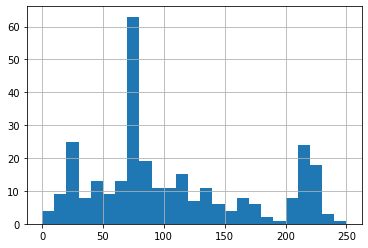

In [159]:
char_freq_distribution(data_tweet['clean_tweet'])

Distiribusi terbanyak yang ditunjukan pada tabel diatas berada pada 20-120 karakter per tweet, dengan mayoritas jumlah kurang dari 10 tweet.

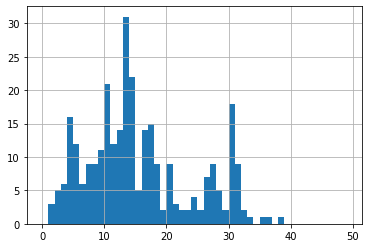

In [160]:
word_len_freq_distribution(data_tweet['clean_tweet'])

Distribusi kata per tweet terbanyak berada pada 8-15 kata.

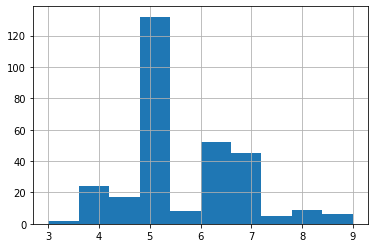

In [161]:
mean_words_freq_distribution(data_tweet['clean_tweet'])

Distribusi terbanyak berada pada 5 & 6-7 karakter per kata per tweet

In [171]:
words_freq_distribution(data_tweet['clean_tweet'])

[('ppkm', 292),
 ('level', 134),
 ('retweet', 108),
 ('itu', 99),
 ('tidak', 84),
 ('kebijakan', 49),
 ('yang', 44),
 ('jangan', 41),
 ('dengan', 41),
 ('nataru', 41),
 ('salah', 40),
 ('paham', 39),
 ('rezim', 39),
 ('tahun', 39),
 ('dari', 35),
 ('alhamdulillah', 34),
 ('eva', 33),
 ('youtube', 33),
 ('dihentikan', 33),
 ('chaniago', 32)]

Distribusi Frekuensi kata terbanyak adalah kata 'ppkm' kemudian 'level' kemudian ada beberapa kata seperti 'kebijakan', 'nataru', 'dihentikan'.

In [172]:
bigram_distribution(data_tweet['clean_tweet'])

(ppkm, level)             130
(itu, itu)                 66
(kebijakan, rezim)         39
(dengan, kebijakan)        39
(paham, dengan)            39
(salah, paham)             39
(jangan, salah)            39
(tahun, alhamdulillah)     34
(alhamdulillah, ppkm)      34
(youtube, itu)             33
(level, dihentikan)        33
(dari, eva)                33
(eva, chaniago)            32
(dihentikan, knp)          28
(umat, islam)              27
(rezim, jkw)               26
(jkw, tahun)               26
(penuh, youtube)           25
(karena, tidak)            25
(islam, tidak)             25
dtype: int64

Dari hasil analisa bigram kita dapat melihat beberapa kata yang sering berkaitan dalam tweet seperti "ppkm & level" dan "kebijakan & rezim". Hasil analisa bigram tersebut dapat menunjukan bahwa mayoritas tweet membahas mengenai kebijakan ppkm yang akan di canangkan oleh pemerintah.

In [173]:
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()

In [183]:
hasil = []
list_negasi = ['kagak','hapus','bubarkan','bubar','tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm', 'Gk']
tweets = list(data_tweet['clean_tweet'])

for tweet in tweets:
    tweet_clean = tweet.strip().split()
    print(tweet_clean)
    
    count_positif = 0
    count_negatif = 0
    
    for word in tweet_clean:
        for negatif_kata in kata_negatif:
            if negatif_kata.strip().lower() == word.lower():
                if tweets[tweets.index(tweet)-1] in list_negasi:
                    print(tweets[tweets.index(tweet)-1], negatif_kata, ['Positif'])
                    count_positif += 1
                else:
                    print(negatif_kata, ['Negatif'])
                    count_negatif += 1
        for positif_kata in kata_positif:
            if positif_kata.strip().lower() == word.lower():
                if tweets[tweets.index(tweet)-1] in list_negasi:
                    print(tweets[tweets.index(tweet)-1], positif_kata, ['Negatif'])
                    count_negatif += 1
                else:
                    print(positif_kata, ['Positif'])
                    count_positif += 1
                    
    print('Positif: '+str(count_positif))
    print('Negatif: '+str(count_negatif))
    hasil.append(count_positif - count_negatif)

    print('-----------------------------------------')
    
print ("Nilai rata-rata: "+str(np.mean(hasil)))
print ("Standar deviasi: "+str(np.std(hasil)))

['rania', 'waalaikumsalam', 'wr', 'wb', 'asyik', 'kalau', 'indonesia', 'bentar', 'ppkm']
asyik
 ['Positif']
Positif: 1
Negatif: 0
-----------------------------------------
['retweet', 'diumumkan', 'ppkm', 'level', 'dari', 'eva', 'chaniago', 'penuh', 'youtube', 'itu', 'itu', 'itu', 'https']
Positif: 0
Negatif: 0
-----------------------------------------
['sat', 'samapta', 'polres', 'pekalongan', 'melaksanakan', 'giat', 'patroli', 'sore', 'antisipasi', 'tindak', 'kriminal', 'melaksanakan', 'pencegahan', 'kerumunan', 'pembagian', 'masker', 'rangka', 'ppkm', 'level', 'mencegah', 'penyebaran', 'virus', 'covid']
giat
 ['Positif']
patroli
 ['Positif']
kriminal
 ['Negatif']
kriminal
 ['Negatif']
virus
 ['Negatif']
Positif: 2
Negatif: 3
-----------------------------------------
['retweet', 'ppkm', 'level', 'wilayah', 'batal', 'moeldoko', 'menyesuaikan', 'kebijakan', 'gas', 'amp', 'rem', 'yess', 'tarik', 'ulur', 'strategi', 'layang']
batal
 ['Negatif']
menyesuaikan
 ['Positif']
Positif: 1
Negati

In [190]:
sentimen = ['Positif' if sentimen >= 0 else 'Negatif' for sentimen in hasil]
data_tweet['sentiment'] = sentimen
jumlah_negatif = data_tweet[data_tweet['sentiment'] == "Negatif"]['sentiment'].count()
jumlah_positif = data_tweet[data_tweet['sentiment'] == "Positif"]['sentiment'].count()
display(data_tweet)
print('Jumlah Sentimen Positif:', jumlah_positif, 'Tweet')
print('Jumlah Sentimen Negatif:', jumlah_negatif, 'Tweet')

,tweet,clean_tweet,sentiment
0,@Billy_Rania Waalaikumsalam wr wb \n\nAsyik do...,rania waalaikumsalam wr wb asyik kalau indones...,Positif
1,RT @YoutubeILC: “Tapi kenapa dalam baru berapa...,retweet diumumkan ppkm level dari eva chaniago...,Positif
2,Sat samapta Polres Pekalongan melaksanakan gia...,sat samapta polres pekalongan melaksanakan gia...,Negatif
3,RT @7AndraVio7: PPKM Level 3 Semua Wilayah Bat...,retweet ppkm level wilayah batal moeldoko meny...,Positif
4,Susah-susah pak Luhut umumin PPKM dan karantin...,susah susah luhut umumin ppkm karantina eh dis...,Negatif
...,...,...,...
295,@kurawa Dia menyuap dan melanggar aturan PPKM.,menyuap melanggar aturan ppkm,Negatif
296,Koramil 08 Tawangmangu - Kamis tanggal 2 Desem...,koramil tawangmangu kamis tanggal desember ser...,Positif
297,RT @syafniir: Pada dasar nya buat kaum adam......,retweet dasar kaum adam diakhir desember gin...,Negatif
298,RT @Hilmi28: Sy berharap smg pembatalan PPKM l...,retweet saya berharap smg pembatalan ppkm leve...,Positif


Jumlah Sentimen Positif: 177 Tweet
Jumlah Sentimen Negatif: 123 Tweet


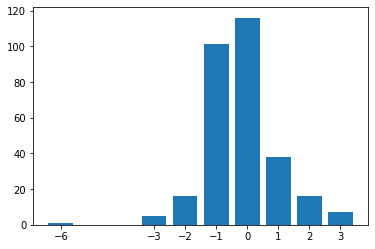

In [191]:
labels, counts = np.unique(hasil, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

Hasil analisa sentimen pada tweet dengan kata kunci "ppkm" pada 7 hari terakhir kecenderungannya kearah sentimen positif, walaupun sentimen negatif juga nilainya masih cukup tinggi.

In [242]:
tweet_gram = [word for tweet in data_tweet["clean_tweet"] for word in tweet.split()]
fdist = nltk.FreqDist(nltk.ngrams(tweet_gram, 2))
list_data = [[k,v]for k,v in fdist.items()]
df_bigram = pd.DataFrame(list_data, columns=['bigram', 'count'])
df_bigram_sort = df_bigram.sort_values(by=["count"], ascending=False).copy().reset_index(drop=True)[:467]
df_bigram_sort

,bigram,count
0,"(ppkm, level)",130
1,"(itu, itu)",66
2,"(kebijakan, rezim)",39
3,"(dengan, kebijakan)",39
4,"(paham, dengan)",39
...,...,...
462,"(stay, lihat)",2
463,"(jakarta, selatan)",2
464,"(ppkm, dibatalin)",2
465,"(natal, ppkm)",2


Graph with 22 nodes and 31 edges


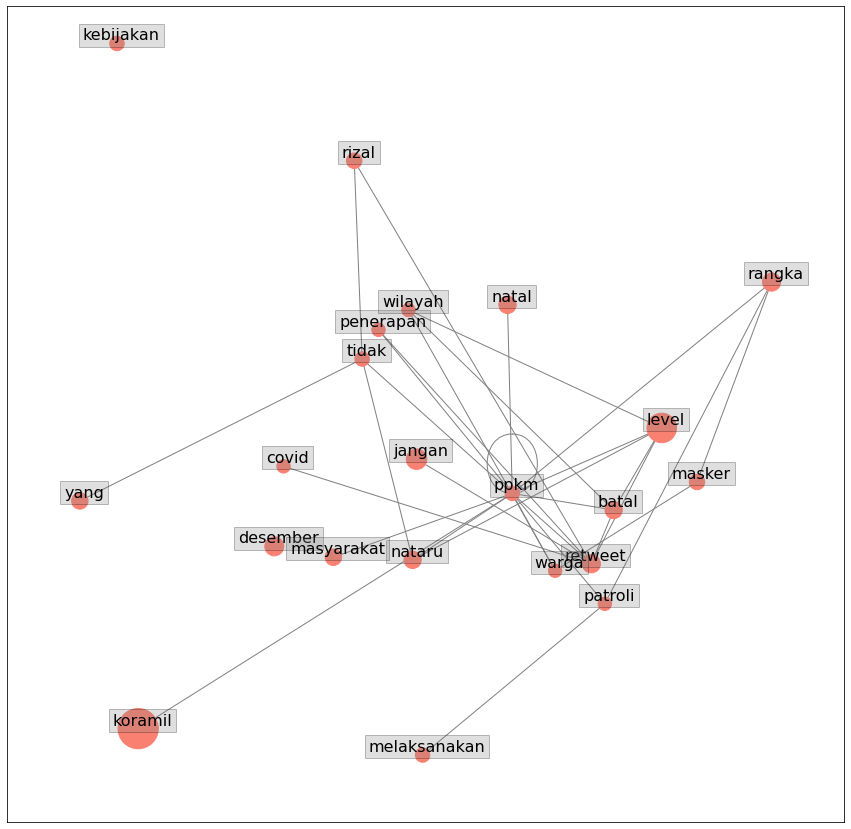

In [291]:
d = df_bigram_sort.set_index("bigram").T.to_dict("records")

G = nx.Graph()

nodes_size = []
for k,v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))
    
deg = G.degree()
items_filter = [n for n in deg if n[1] > 5]
node = [node[0] for node in items_filter]
degree = [node[1]*30 for node in items_filter]

fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(G, k=1.5)
k = G.subgraph(node)
print(k)

nx.draw_networkx(k, pos=pos,
        font_size=12,
        width=1,
        edge_color='grey',
        node_color='salmon',
        with_labels = False,
        node_size = degree,
        ax=ax)

for key, value in pos.items():
    if key in node:
        x, y = value[0]+.005, value[1]+.005
        ax.text(x, y,
            s=key,
            bbox=dict(facecolor='grey', alpha=0.25),
            horizontalalignment='center', fontsize=16)
    
plt.show()

Hasil analisa network atau keterhubungan kata dari data tweet, dapat dilihat beberapa kata yang memiliki keterhubungan seperti 'ppkm', 'level', 'nataru', 'warga', 'masker'.

* Topik ekstraksi dan analisis pada Headline berita mengenai ppkm selama beberapa hari terkhir.

In [208]:
#Topik extraction dan analisi
berita = [berita.split() for berita in data_news['News']]

dictionary = corpora.Dictionary(berita)
doc_term_metric = [dictionary.doc2bow(doc) for doc in berita]

Lda = gensim.models.ldamodel.LdaModel
model_lda = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_metric, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

coherence_model_lda = CoherenceModel(model=model_lda, texts=berita, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


Coherence Score: 0.4657063042939787


In [213]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_metric,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=berita, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [214]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_metric)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(doc_term_metric, num_of_docs*0.75), 
               doc_term_metric]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    pbar.close()

100%|██████████| 540/540 [1:11:58<00:00,  8.00s/it]


In [217]:
pd.DataFrame(model_results).to_csv('lda_tuning_result.csv', index=False)
df_tuning_result = pd.read_csv('lda_tuning_result.csv')
df_tuning_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.439579
1,75% Corpus,2,0.01,0.31,0.429343
2,75% Corpus,2,0.01,0.61,0.444287
3,75% Corpus,2,0.01,0.9099999999999999,0.448399
4,75% Corpus,2,0.01,symmetric,0.446327
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.414916
536,100% Corpus,10,asymmetric,0.31,0.347152
537,100% Corpus,10,asymmetric,0.61,0.353643
538,100% Corpus,10,asymmetric,0.9099999999999999,0.319424


<AxesSubplot:xlabel='Topics'>

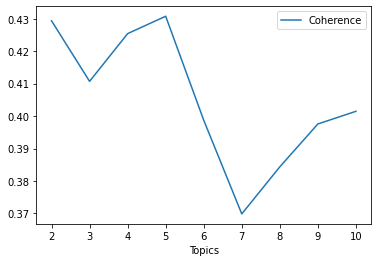

In [226]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [223]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 4) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
343,100% Corpus,4,0.61,0.9099999999999999,0.475352
330,100% Corpus,4,0.01,0.01,0.466867
342,100% Corpus,4,0.61,0.61,0.458744
347,100% Corpus,4,0.9099999999999999,0.61,0.448581
348,100% Corpus,4,0.9099999999999999,0.9099999999999999,0.442829
355,100% Corpus,4,asymmetric,0.01,0.439631
336,100% Corpus,4,0.31,0.31,0.438846
339,100% Corpus,4,0.31,symmetric,0.438846
344,100% Corpus,4,0.61,symmetric,0.438606
337,100% Corpus,4,0.31,0.61,0.436669


In [229]:
lda_model = gensim.models.LdaMulticore(corpus=doc_term_metric,
                                           id2word=dictionary,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.9)

from pprint import pprint
pprint(lda_model.print_topics())
print("Topik 1: Pertumbuhan ekonomi dan Pertambahan kasus corona bulan Desember")
print("Topik 2: Pembatalan PPKM level 3 saat Nataru")
print("Topik 3: Kegiatan Muktamar dan hiburan karaoke pada bulan desember")
print("Topik 4: Kebijakan PPKM dan prokes saat natal dan tahun baru")

[(0,
  '0.010*"RI" + 0.006*"2" + 0.006*"Kasus" + 0.005*"Ekonomi" + 0.005*"Desember" '
  '+ 0.005*"Siapkan" + 0.005*"Tambah" + 0.005*"Corona" + 0.005*"Tumbuh" + '
  '0.005*"Karaoke"'),
 (1,
  '0.056*"PPKM" + 0.054*"Level" + 0.051*"3" + 0.039*"Nataru" + 0.026*"Batal," '
  '+ 0.019*"Saat" + 0.013*"Aturan" + 0.012*"Ini" + 0.011*"Tetap" + '
  '0.009*"Batal"'),
 (2,
  '0.010*"Muktamar" + 0.010*"NU" + 0.007*"Ini" + 0.005*"2021" + 0.005*"hingga" '
  '+ 0.005*"Digelar" + 0.005*"Desember" + 0.005*"Karaoke" + 0.005*"Jakarta" + '
  '0.005*"Pastikan"'),
 (3,
  '0.023*"di" + 0.011*"Baru" + 0.009*"Tahun" + 0.008*"dan" + 0.008*"Bandung" + '
  '0.008*"Prokes" + 0.007*"PPKM" + 0.006*"Natal" + 0.006*"Luhut" + '
  '0.005*"Level"')]
Topik 1: Pertumbuhan ekonomi dan Pertambahan kasus corona bulan Desember
Topik 2: Pembatalan PPKM level 3 saat Nataru
Topik 3: Kegiatan Muktamar dan hiburan karaoke pada bulan desember
Topik 4: Kebijakan PPKM dan prokes saat natal dan tahun baru


Hasil ekstraksi dan analisis topik dari headline berita dari portal berita detik.com menghasilkan 4 topik yang banyak dijadikan headline berita yaitu:

Topik 1: Pertumbuhan ekonomi dan Pertambahan kasus corona bulan Desember

Topik 2: Pembatalan PPKM level 3 saat Nataru

Topik 3: Kegiatan Muktamar dan hiburan karaoke pada bulan desember

Topik 4: Kebijakan PPKM dan prokes saat natal dan tahun baru

# Kesimpulan:
* Bahwa dilihat dari hasil analisis pada data tweet mengenai ppkm memiliki sentimen dengan kecenderungan positif. Kemudian, mencermati keterhubungan kata pada data tweet, topik yang dibahas masyarakat twitter tentang ppkm tidak lepas dari pembahasan kebijakan ppkm pada bulan desember saat Nataru (natal dan tahun baru).
* kecenderungan sentimen kearah positif dapat diperkiran karena pemberitaan mengenai kebijakan baru yang dikeluarkan pemerintah saat natal dan tahun baru yaitu pembataln PPKM level 3.

